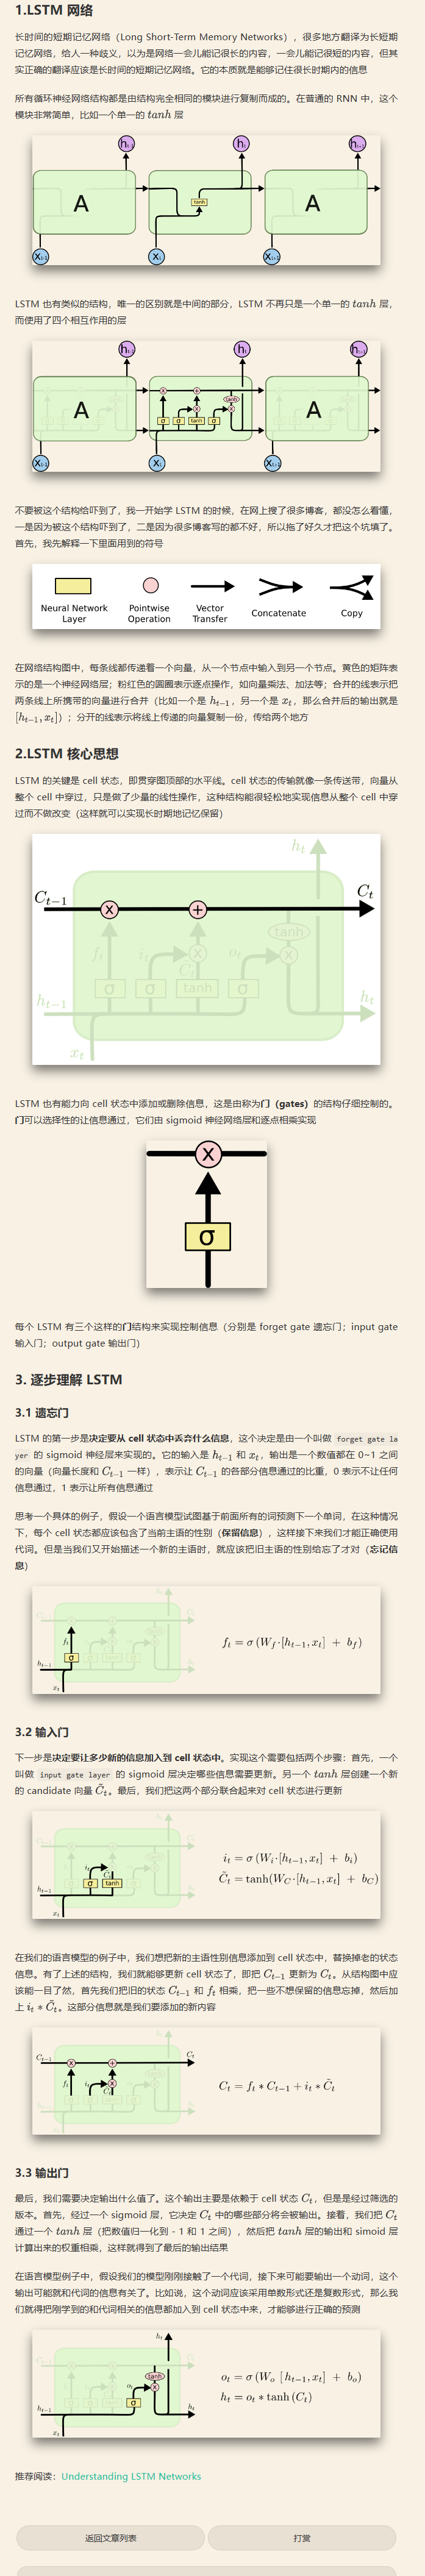

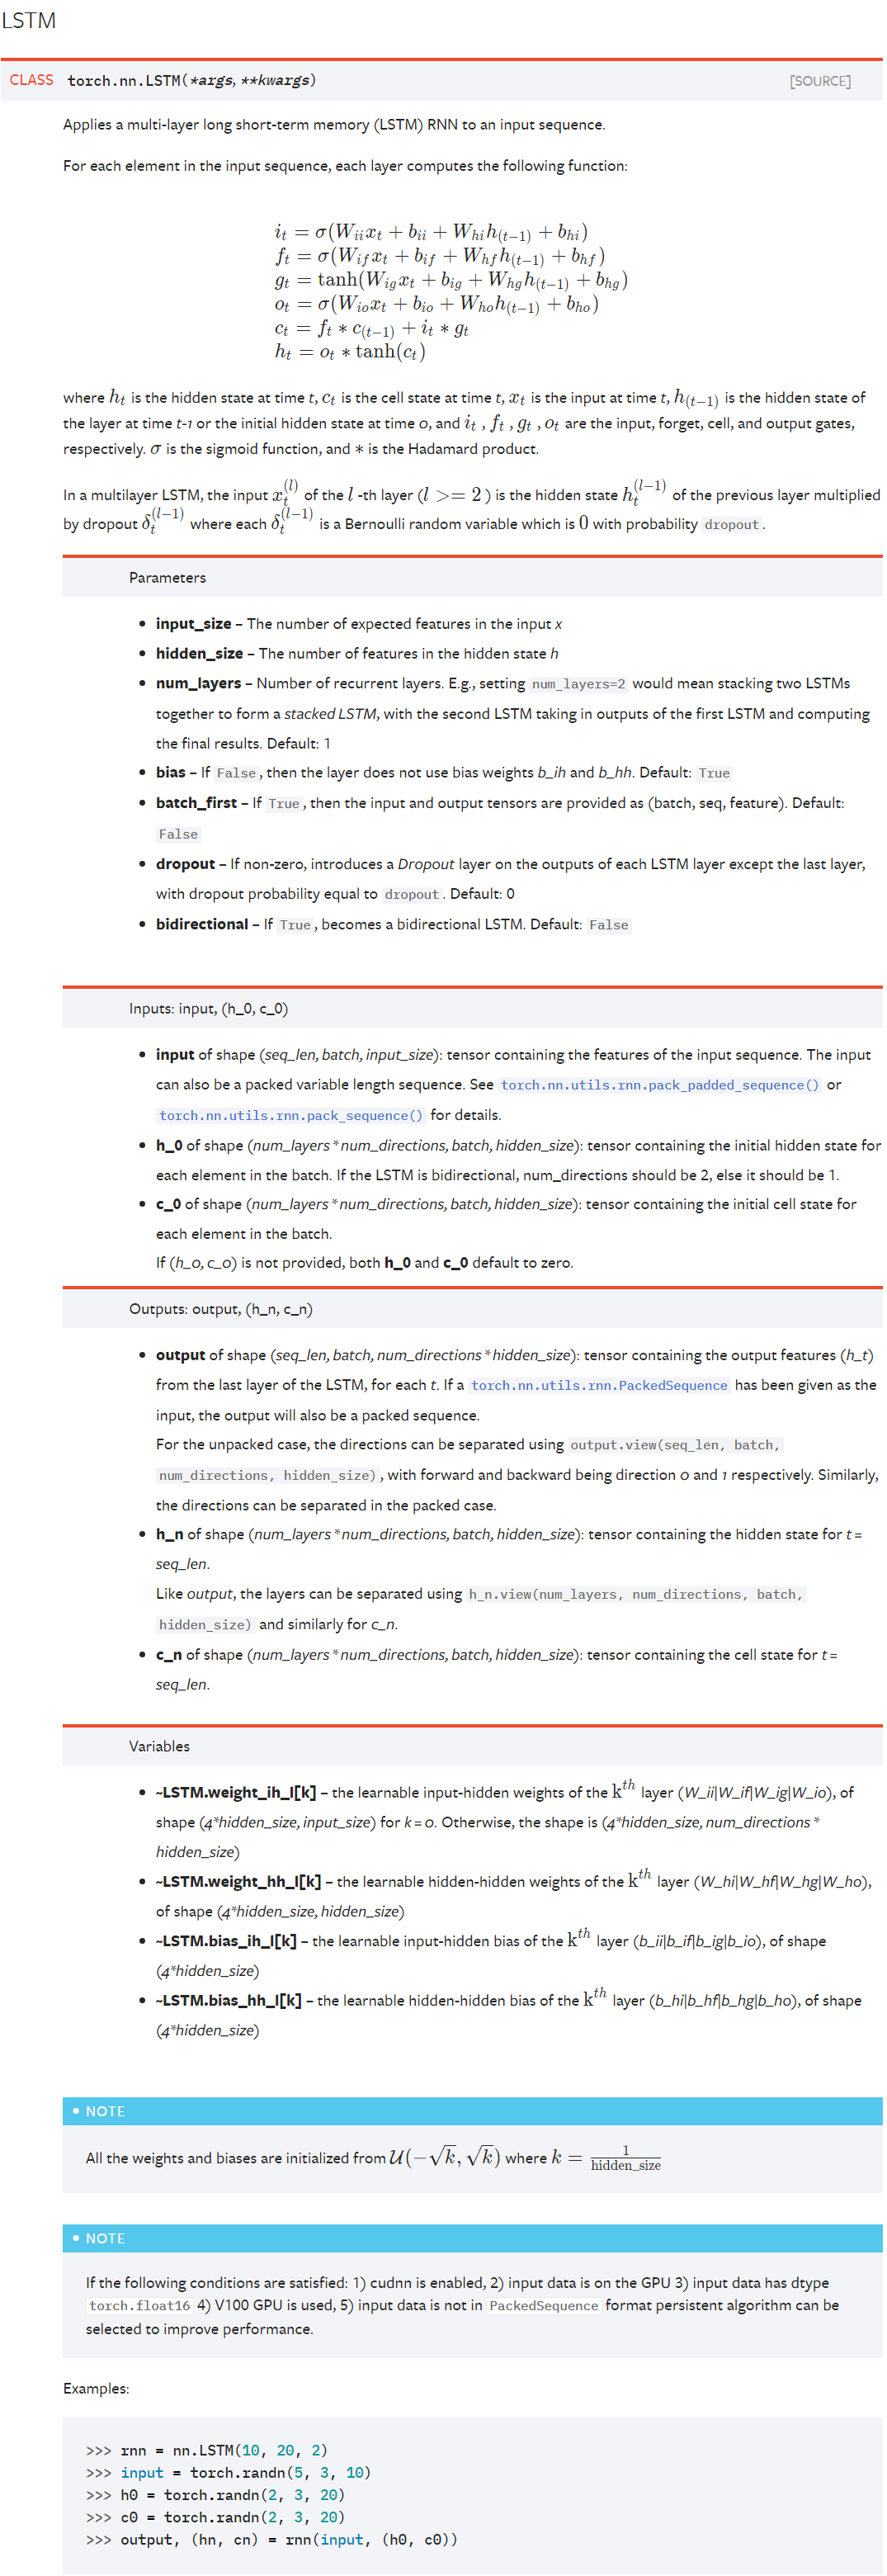

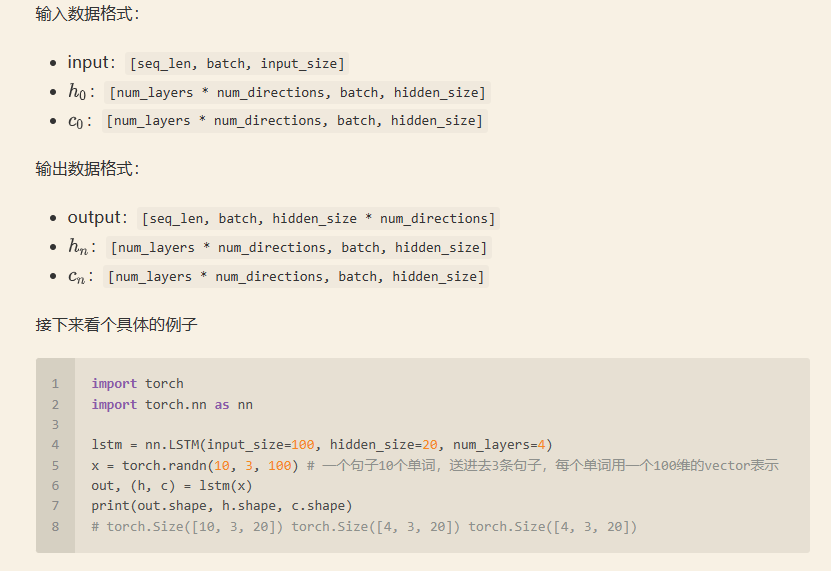

In [2]:
import torch
import torch.nn as nn

lstm = nn.LSTM(input_size=100, hidden_size=20, num_layers=4)
x = torch.randn(10, 3, 100) # 一个句子10个单词，送进去3条句子，每个单词用一个100维的vector表示
"""
out 的维数为：【seq_len. batch, hidden_size*num_directions】
             【一个句子的长度，一次性处理多少个句子，改变编码为多少维】
h   的维数为：[num_layers * num_directions, batch, hidden_size]
            【num_layers 表示行数 其实就是多少个LSTM，一次性处理多少个句子，改变编码为多少维】
c   的维数为：[num_layers * num_directions, batch, hidden_size]
            【num_layers 表示行数 其实就是多少个LSTM，一次性处理多少个句子，改变编码为多少维】
"""
out, (h, c) = lstm(x)
print(out.shape, h.shape, c.shape)
# torch.Size([10, 3, 20]) torch.Size([4, 3, 20]) torch.Size([4, 3, 20])

torch.Size([10, 3, 20]) torch.Size([4, 3, 20]) torch.Size([4, 3, 20])


In [3]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, modify by wmathor
'''
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

dtype = torch.FloatTensor

In [8]:
"""
准备数据
"""
sentence = (
    'GitHub Actions makes it easy to automate all your software workflows '
    'from continuous integration and delivery to issue triage and more'
)

word2idx = {w: i for i, w in enumerate(list(set(sentence.split())))}
idx2word = {i: w for i, w in enumerate(list(set(sentence.split())))}
n_class = len(word2idx) # classification problem
max_len = len(sentence.split())
n_hidden = 5

In [9]:
sentence.split()

['GitHub',
 'Actions',
 'makes',
 'it',
 'easy',
 'to',
 'automate',
 'all',
 'your',
 'software',
 'workflows',
 'from',
 'continuous',
 'integration',
 'and',
 'delivery',
 'to',
 'issue',
 'triage',
 'and',
 'more']

In [5]:
def make_data(sentence):
    input_batch = []
    target_batch = []

    words = sentence.split()
    for i in range(max_len - 1):
        input = [word2idx[n] for n in words[:(i + 1)]]
        input = input + [0] * (max_len - len(input))
        target = word2idx[words[i + 1]]
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return torch.Tensor(input_batch), torch.LongTensor(target_batch)

# input_batch: [max_len - 1, max_len, n_class]
input_batch, target_batch = make_data(sentence)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, 16, True)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  del sys.path[0]


In [6]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, bidirectional=True)
        # fc
        self.fc = nn.Linear(n_hidden * 2, n_class)

    def forward(self, X):
        # X: [batch_size, max_len, n_class]
        batch_size = X.shape[0]
        input = X.transpose(0, 1)  # input : [max_len, batch_size, n_class]

        hidden_state = torch.randn(1*2, batch_size, n_hidden)   # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.randn(1*2, batch_size, n_hidden)     # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state))
        outputs = outputs[-1]  # [batch_size, n_hidden * 2]
        model = self.fc(outputs)  # model : [batch_size, n_class]
        return model

model = BiLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training
for epoch in range(10000):
    for x, y in loader:
      pred = model(x)
      loss = criterion(pred, y)
      if (epoch + 1) % 1000 == 0:
          print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

# Pred
predict = model(input_batch).data.max(1, keepdim=True)[1]
print(sentence)
print([idx2word[n.item()] for n in predict.squeeze()])

Epoch: 1000 cost = 1.751500
Epoch: 1000 cost = 1.811335
Epoch: 2000 cost = 1.323137
Epoch: 2000 cost = 1.413242
Epoch: 3000 cost = 1.069637
Epoch: 3000 cost = 1.380191
Epoch: 4000 cost = 1.007105
Epoch: 4000 cost = 0.952274
Epoch: 5000 cost = 0.880268
Epoch: 5000 cost = 0.811305
Epoch: 6000 cost = 0.702721
Epoch: 6000 cost = 1.232290
Epoch: 7000 cost = 0.678963
Epoch: 7000 cost = 0.948513
Epoch: 8000 cost = 0.646245
Epoch: 8000 cost = 0.531243
Epoch: 9000 cost = 0.527283
Epoch: 9000 cost = 0.583663
Epoch: 10000 cost = 0.418771
Epoch: 10000 cost = 0.594682
GitHub Actions makes it easy to automate all your software workflows from continuous integration and delivery to issue triage and more
['makes', 'makes', 'it', 'easy', 'to', 'automate', 'all', 'your', 'software', 'workflows', 'from', 'continuous', 'integration', 'delivery', 'delivery', 'to', 'to', 'triage', 'more', 'more']
